In [220]:
from __future__ import annotations

import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy

import importlib

import template, utility
[importlib.reload(lib) for lib in (template, utility)]

[<module 'template' from '/Users/barrels/Documents/Projects/RL/Rl Batrlow Andrew/template.py'>,
 <module 'utility' from '/Users/barrels/Documents/Projects/RL/Rl Batrlow Andrew/utility.py'>]

Eg 4.1) GridWorld

In [221]:
class GridWorld:

    S = list(range(1, 15))+['t']

    A = ['up', 'down', 'left', 'right']

    def get_action_space(self, s):
        return self.A

    def next_state_and_reward_probabilities(self, s, a):
        """Returns tuple with elements as p, s_, r (i.e probability, next state and reward)"""
        if s == 't': ans = 't', 0
        
        elif a == 'up':
            if s==4: ans = 't', -1
            elif s-4 > 0: ans = s-4, -1
            else: ans = s, -1
        
        elif a == 'down':
            if s==11: ans = 't', -1
            elif s+4 < 15: ans =  s+4, -1
            else: ans = s, -1
        
        elif a == 'left':
            if s==1: ans = 't', -1
            elif s%4 != 0: ans = s-1, -1
            else: ans = s, -1
        
        elif a == 'right':
            if s==14: ans = 't', -1
            elif s%4 != 3: ans = s+1, -1
            else: ans = s, -1

        return ((1, ans[0], ans[1]),)

    def plot(self, V, title):
        print(title)
        vals = [V['t']] + [V[i] for i in range(1, 15)] + [V['t']]
        for i in range(4):
            for j in range(4):
                print(f'{vals.pop(0):6.4f}', end=' ')
            print()
        print()

gridworld = GridWorld()

In [222]:
def equiprobable_random_policy(s, A):
    len_A = len(A)
    return (1/len_A,) * len_A

In [223]:
def iterative_policy_evaluation(world: GridWorld, policy_action_probs, V=None, thetha=0.1, gamma=0.9, plotter=None, do_plot=False):

    if plotter is None and hasattr(world, 'plot'): plotter = world.plot

    if V is None:
        V = {}
        for s in world.S:
            V[s] = 0

    if do_plot and plotter: plotter(V, 'Initial V:')

    t = 0
    while True:
        delta = 0

        for s in world.S:
            A = world.get_action_space(s)
            v = V[s]

            V[s] = 0
            for a, policy_action_probability in zip(A, policy_action_probs(s, A)):
                for next_state_prob, s_, r in world.next_state_and_reward_probabilities(s, a):
                    V[s] += policy_action_probability * next_state_prob * (r + gamma * V[s_])

            delta = max(delta, abs(v - V[s]))

        if do_plot and plotter: plotter(V, f'V at Time step {t}:')
        
        if delta < thetha: break

        t += 1

    return V

In [224]:
iterative_policy_evaluation(gridworld, equiprobable_random_policy, thetha=0.01, gamma=1, do_plot=True)

Initial V:
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 

V at Time step 0:
0.0000 -1.0000 -1.2500 -1.5781 
-1.1250 -1.5312 -1.6953 -2.2104 
-1.4766 -1.7520 -1.8618 -2.4601 
-1.7799 -2.0550 -2.1581 0.0000 

V at Time step 1:
0.0000 -1.6953 -2.2422 -2.5789 
-1.9692 -2.7780 -3.2731 -3.7850 
-2.7346 -3.3573 -3.8121 -3.5616 
-2.7851 -3.3474 -3.0907 0.0000 

V at Time step 2:
0.0000 -2.2550 -3.0268 -3.3162 
-2.6740 -3.8899 -4.6285 -4.7832 
-3.6703 -4.6799 -4.9902 -4.2417 
-3.4737 -4.1661 -3.6634 0.0000 

V at Time step 3:
0.0000 -2.7292 -3.6685 -3.8286 
-3.2444 -4.8205 -5.5656 -5.4487 
-4.3944 -5.5928 -5.7659 -4.6921 
-3.9612 -4.7164 -4.0434 0.0000 

V at Time step 4:
0.0000 -3.1222 -4.1291 -4.1806 
-3.7034 -5.4960 -6.2099 -5.9008 
-4.9184 -6.2242 -6.2924 -4.9979 
-4.3035 -5.0943 -4.3024 0.0000 

V at Time step 5:
0.0000 -3.4063 -4.4492 -4.4219 
-4.0360 -5.9691 -6.6529 -6.2102 
-5.2871 -6.6607 -6.6535 -5.2074 
-4.5420 -5.

{1: -4.035349259240877,
 2: -5.1461224445799,
 3: -4.944425978357517,
 4: -4.78061935924559,
 5: -7.008568122159204,
 6: -7.6160653890570345,
 7: -6.881166344259336,
 8: -6.103794308844341,
 9: -7.61694014526182,
 10: -7.439547912500729,
 11: -5.662723205237519,
 12: -5.067886613572034,
 13: -5.926251744154512,
 14: -4.868921658695106,
 't': 0.0}

In [225]:
def policy_iteration(world: GridWorld, V=None, policy=None, thetha=0.1, gamma=0.9, plotter=None, do_plot=False, do_eval_plot=False):

    if plotter is None and hasattr(world, 'plot'): plotter = world.plot

    if V is None:
        V = {}
        for s in world.S:
            V[s] = 0

    if policy is None:
        policy = {}
        for s in world.S:
            A = world.get_action_space(s)
            policy[s] = random.choice(list(A))

    if do_plot and plotter: plotter(V, 'Initial V:')

    t = 0
    while True:
        def policy_action_probs(s, A):
            return np.eye(len(A))[list(A).index(policy[s])]

        V = iterative_policy_evaluation(world, policy_action_probs, V, thetha, gamma, do_plot=do_eval_plot)

        policy_stable = True

        for s in world.S:
            A = world.get_action_space(s)

            old_action = policy[s]

            max_G = -math.inf

            for a in A:
                G = 0
                for next_state_prob, s_, r in world.next_state_and_reward_probabilities(s, a):
                    G = next_state_prob * (r + gamma * V[s_])
                    
                if max_G < G:
                    policy[s] = a
                    max_G = G

            if old_action != policy[s]:
                policy_stable = False

        if do_plot and plotter: plotter(V, f'V at Time step {t}:')

        if policy_stable: break

        t += 1

    return V

In [226]:
policy_iteration(gridworld, thetha=0.1, gamma=0.9, do_plot=True)

Initial V:
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 

V at Time step 0:
0.0000 -1.0000 -1.9000 -1.0000 
-3.4390 -4.0951 -2.7100 -9.6185 
-2.7100 -1.9000 -1.9000 -9.6566 
-1.9000 -1.0000 -1.0000 0.0000 

V at Time step 1:
0.0000 -1.0000 -1.9000 -1.0000 
-1.0000 -1.9000 -2.7100 -1.9000 
-2.7100 -1.9000 -1.9000 -1.0000 
-1.9000 -1.0000 -1.0000 0.0000 

V at Time step 2:
0.0000 -1.0000 -1.9000 -1.0000 
-1.0000 -1.9000 -2.7100 -1.9000 
-1.9000 -1.9000 -1.9000 -1.0000 
-1.9000 -1.0000 -1.0000 0.0000 



{1: -1.0,
 2: -1.9,
 3: -1.0,
 4: -1.0,
 5: -1.9,
 6: -2.71,
 7: -1.9,
 8: -1.9,
 9: -1.9,
 10: -1.9,
 11: -1.0,
 12: -1.9,
 13: -1.0,
 14: -1.0,
 't': 0.0}

In [227]:
factorials = [1]
for i in range(1, 12):
    factorials.append(factorials[-1]*i)

def poission_prob(l, n):
    return l ** n / factorials[n] * math.exp(-l)

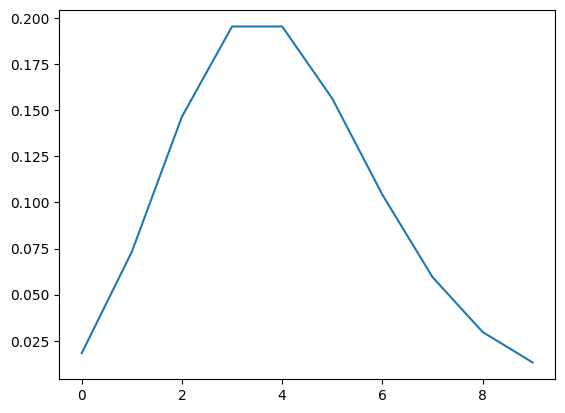

In [228]:
n = 10
x = np.linspace(0, n-1, n)
l = 4  # lambda
y = l ** x / scipy.special.factorial(x) * math.exp(-l)
y = [poission_prob(l, int(xi)) for xi in x]

plt.plot(x, y)

In [229]:
class JackCarRentalWorld:

    # Poission distribution arguments
    request_i_lambda = 3
    request_j_lambda = 4
    return_i_lambda = 3
    return_j_lambda = 2
    
    S = {(i, j) for i in range(21) for j in range(21)}

    A = set(range(-5, 6))

    def next_state_and_reward_probabilities(self, s, a):
        """Returns p, s_, r (i.e probability, next state and reward)"""
        i, j = s

        results = []

        max_requests = 10
        max_returns = 10
        for request_i in range(0, max_requests+1):
            for request_j in range(0, max_requests+1):
                for return_i in range(0, max_returns+1):
                    for return_j in range(0, max_returns+1):
                        prob = poission_prob(self.request_i_lambda, request_i)
                        prob *= poission_prob(self.request_j_lambda, request_j)
                        prob *= poission_prob(self.return_i_lambda, return_i)
                        prob *= poission_prob(self.return_j_lambda, return_j)
                        i_ = min(20, max(0, i - request_i) + return_i)
                        j_ = min(20, max(0, j - request_j) + return_j)
                        reward = min(i, request_i) * 10 + min(j, request_j) * 10 - abs(a) * 2
                        results.append((prob, (i_, j_), reward))

        return results

    def plot(self, V, title):
        print(title)
        for i in range(21):
            for j in range(21):
                print(V[(i, j)], end=' ')
            print()

        print()

jackcarrentalworld = JackCarRentalWorld()

In [230]:
#Takes too long to run
# policy_iteration(jackcarrentalworld, thetha=0.1, gamma=0.9, do_plot=True, do_eval_plot=True)

# Value Iteration

In [231]:
def policy_iteration(world: GridWorld, V=None, policy=None, thetha=0.1, gamma=0.9, plotter=None, do_plot=False):

    if plotter is None and hasattr(world, 'plot'): plotter = world.plot

    if V is None:
        V = {}
        for s in world.S:
            V[s] = 0

    if policy is None:
        policy = {}
        for s in world.S:
            A = world.get_action_space(s)
            policy[s] = random.choice(list(A))

    if do_plot and plotter: plotter(V, 'Initial V:')

    t = 0
    while True:
        delta = 0

        for s in world.S:
            A = world.get_action_space(s)
            v = V[s]

            best_a = None
            best_a_estimate = -math.inf
            for a in A:
                a_estimate = 0
                for p, s_, r in world.next_state_and_reward_probabilities(s, a):
                    a_estimate += p * (r + gamma * V[s_])

                if a_estimate > best_a_estimate:
                    best_a = a
                    best_a_estimate = a_estimate
            V[s] = best_a_estimate

            delta = max(delta, abs(v-V[s]))


        if do_plot and plotter: plotter(V, f'V at Time step {t}:')

        if delta < thetha: break

        t += 1

    return V

In [232]:
policy_iteration(gridworld, do_plot=True)

Initial V:
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 
0.0000 0.0000 0.0000 0.0000 

V at Time step 0:
0.0000 -1.0000 -1.0000 -1.0000 
-1.0000 -1.0000 -1.0000 -1.0000 
-1.0000 -1.0000 -1.0000 -1.0000 
-1.0000 -1.0000 -1.0000 0.0000 

V at Time step 1:
0.0000 -1.0000 -1.9000 -1.9000 
-1.0000 -1.9000 -1.9000 -1.9000 
-1.9000 -1.9000 -1.9000 -1.0000 
-1.9000 -1.9000 -1.0000 0.0000 

V at Time step 2:
0.0000 -1.0000 -1.9000 -2.7100 
-1.0000 -1.9000 -2.7100 -1.9000 
-1.9000 -2.7100 -1.9000 -1.0000 
-2.7100 -1.9000 -1.0000 0.0000 

V at Time step 3:
0.0000 -1.0000 -1.9000 -2.7100 
-1.0000 -1.9000 -2.7100 -1.9000 
-1.9000 -2.7100 -1.9000 -1.0000 
-2.7100 -1.9000 -1.0000 0.0000 



{1: -1.0,
 2: -1.9,
 3: -2.71,
 4: -1.0,
 5: -1.9,
 6: -2.71,
 7: -1.9,
 8: -1.9,
 9: -2.71,
 10: -1.9,
 11: -1.0,
 12: -2.71,
 13: -1.9,
 14: -1.0,
 't': 0.0}

# Gamblers Problem

In [233]:
class GamblersProblem:

    S = list(range(1, 100)) + [0, 100]

    def __init__(self, ph) -> None:
        # ph: probability of heads
        self.ph = ph

    def get_action_space(self, s):
        return list(range(0, min(s, 100-s)+1))

    def next_state_and_reward_probabilities(self, s, a):
        """Returns p, s_, r (i.e probability, next state and reward)"""
        if s == 0: return ((1, s, 0),)
        if s == 100: return ((1, s, 0),)

        win_reward = int(s + a == 100)
        lose_reward = -int(s - a == 0)
        
        return (self.ph, s+a, win_reward), (1-self.ph, s-a, lose_reward)
    
    def plot(self, V, title):
        plt.title(title)

        values = [V[s] for s in self.S[0:-2]]
        plt.plot(values)
        plt.show()

    def plot_policy(self, V):
        plt.title('Current greedy policy based on V')

        greedy_policy = {}
        for s in self.S:
            best_a, best_a_val = None, -math.inf
            for a in self.get_action_space(s):
                a_val = 0
                for p, s_, r in self.next_state_and_reward_probabilities(s, a):
                    a_val += p * V[s_]

                if a_val > best_a_val:
                    best_a, best_a_val = a, a_val

            greedy_policy[s] = best_a

        plt.plot([s for s in self.S[:-2]], [greedy_policy[s] for s in self.S[:-2]])
        plt.show()

gamblers_problem = GamblersProblem(ph = 0.4)

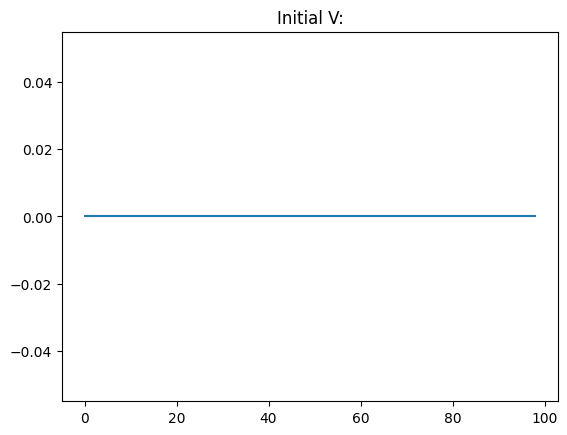

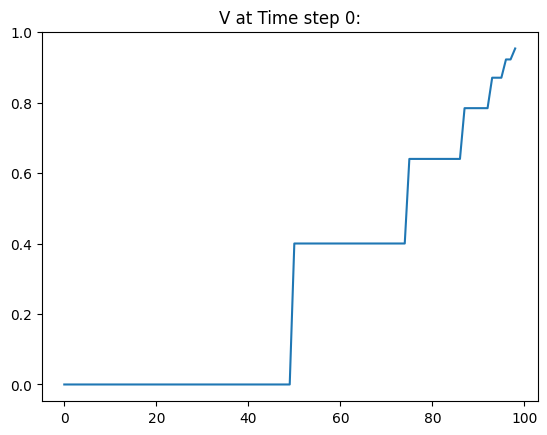

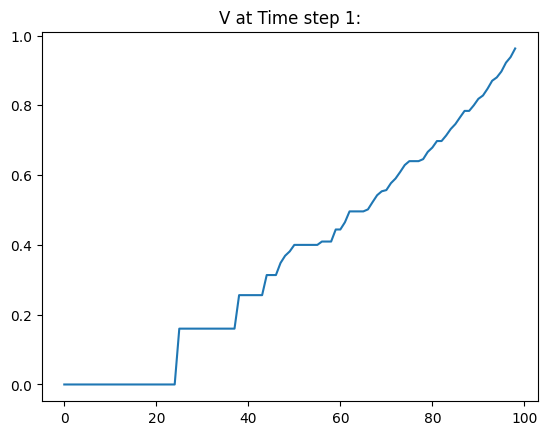

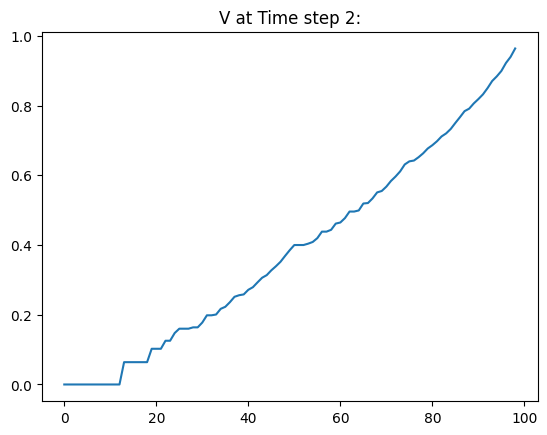

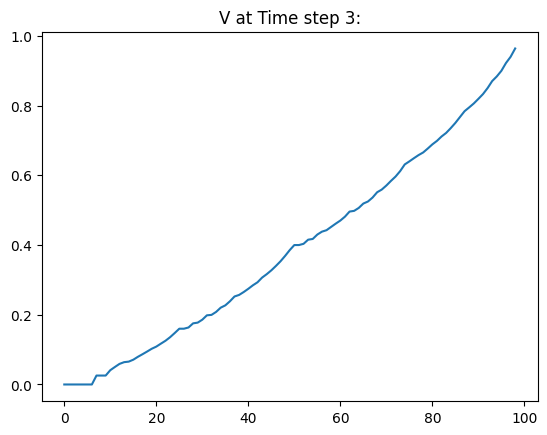

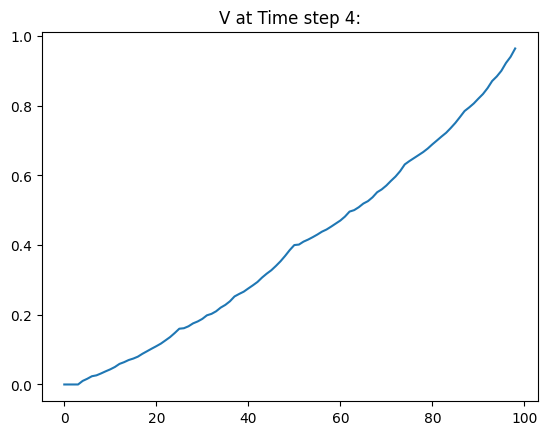

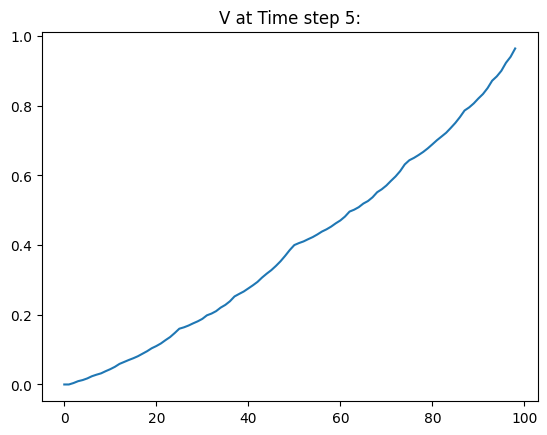

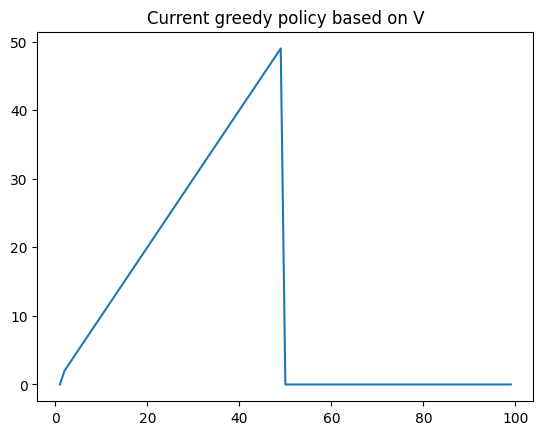

In [234]:
gamblers_problem = GamblersProblem(ph = 0.4)

V = policy_iteration(gamblers_problem, thetha=0.01, gamma=1, do_plot=True)

gamblers_problem.plot_policy(V)

Greedy Policy is different from one shown in textbook! (pg 84)